In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import time
import seaborn as sns
from src.load_shapes import load_all_shape_datasets

from D_oblique_decision_trees.converters.dispatcher import convert_tree
from D_oblique_decision_trees.visualisation import plot_decision_boundaries, print_tree_structure

from evaluation.evaluator import evaluate_tree

from Ensembles_of_Oblique_Decision_Trees.Decision_trees.HouseHolder_CART import HHCartClassifier
from Ensembles_of_Oblique_Decision_Trees.Decision_trees.RandCART import RandCARTClassifier
from Ensembles_of_Oblique_Decision_Trees.Decision_trees.Oblique_Classifier_1 import ObliqueClassifier1
from Ensembles_of_Oblique_Decision_Trees.Decision_trees.WODT import WeightedObliqueDecisionTreeClassifier
from Ensembles_of_Oblique_Decision_Trees.Decision_trees.segmentor import MeanSegmentor
from Ensembles_of_Oblique_Decision_Trees.Decision_trees.split_criteria import gini

In [2]:
# Load & scale dataset
datasets = load_all_shape_datasets()
X, y = datasets["barbell_2d"]

Starting CSV file loading process from ..\_data\shapes

Paired dataset 'barbell_2d': X shape (5000, 2), y shape (5000,)
Paired dataset 'barbell_3d': X shape (10000, 3), y shape (10000,)
Paired dataset 'radial_segment_2d': X shape (5000, 2), y shape (5000,)
Paired dataset 'radial_segment_3d': X shape (10000, 3), y shape (10000,)
Paired dataset 'rectangle_2d': X shape (5000, 2), y shape (5000,)
Paired dataset 'saddle_3d': X shape (10000, 3), y shape (10000,)
Paired dataset 'sine_wave_2d': X shape (5000, 2), y shape (5000,)
Paired dataset 'star_2d': X shape (5000, 2), y shape (5000,)

Datasets available: ['barbell_2d', 'barbell_3d', 'radial_segment_2d', 'radial_segment_3d', 'rectangle_2d', 'saddle_3d', 'sine_wave_2d', 'star_2d']


In [3]:
model_registry = {
    "hhcart": lambda: HHCartClassifier(impurity=gini, segmentor=MeanSegmentor(), max_depth=7),
    "randcart": lambda: RandCARTClassifier(impurity=gini, segmentor=MeanSegmentor(), max_depth=7),
    "oc1": lambda: ObliqueClassifier1(max_depth=7, min_samples_split=2),
    "wodt": lambda: WeightedObliqueDecisionTreeClassifier(max_depth=7, min_samples_split=2, max_features='all')
}

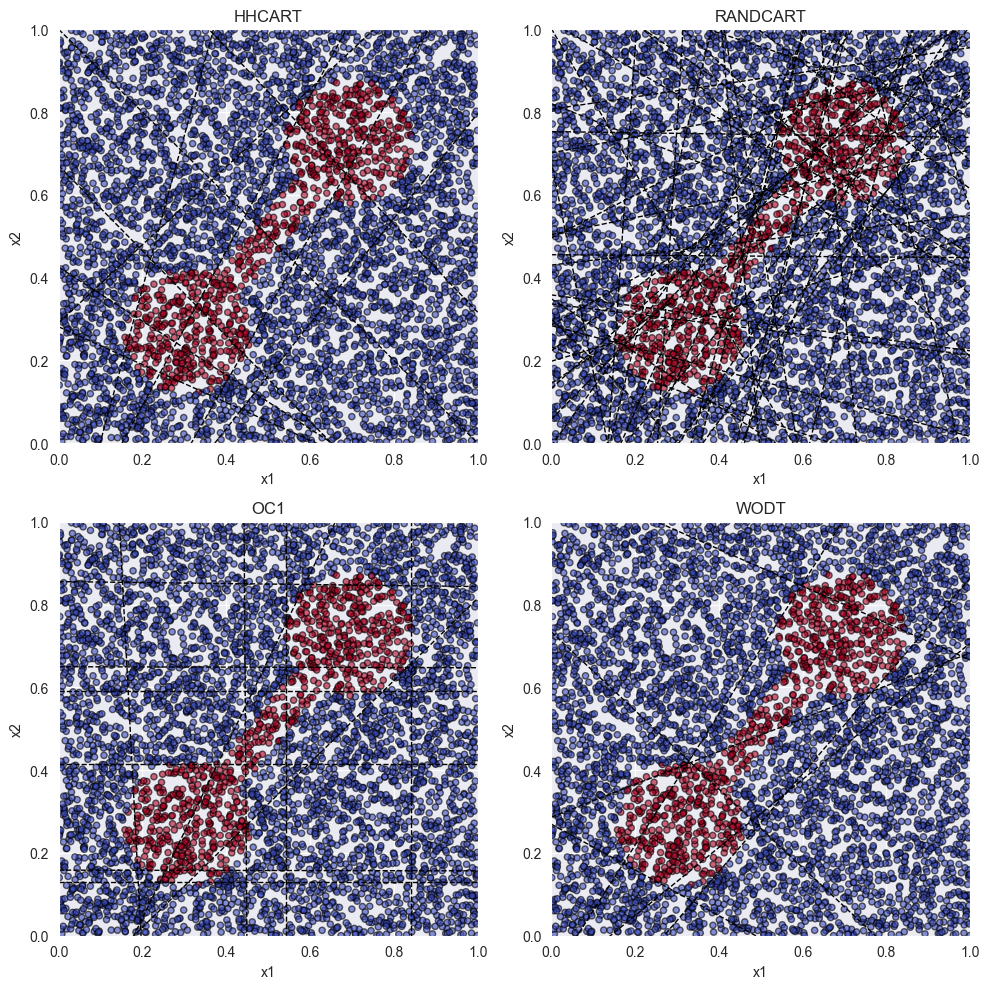

In [4]:
ncols = 2
nrows = (len(model_registry) + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows))
axes = axes.flatten()

for i, (model_type, constructor) in enumerate(model_registry.items()):
    model = constructor()
    model.fit(X, y)

    tree = convert_tree(model, model_type=model_type)
    ax = axes[i]
    # print_tree_structure(tree)
    plot_decision_boundaries(tree, X, y, ax=ax, xlim=(0, 1), ylim=(0, 1))
    ax.set_title(f"{model_type.upper()}")

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# Filter to 2D datasets only
datasets_2d = {name: (X, y) for name, (X, y) in datasets.items() if X.shape[1] == 3}

results = []

for dataset_name, (X, y) in datasets_2d.items():
    for model_name, constructor in model_registry.items():
        print(f"Running {model_name} on {dataset_name}...")
        model = constructor()

        start = time.time()
        model.fit(X, y)
        end = time.time()

        tree = convert_tree(model, model_type=model_name)

        metrics = evaluate_tree(tree, X, y, training_time=end - start)
        metrics["model"] = model_name
        metrics["dataset"] = dataset_name
        results.append(metrics)

df_results = pd.DataFrame(results)

Running hhcart on barbell_3d...
Running randcart on barbell_3d...
Running oc1 on barbell_3d...
Running wodt on barbell_3d...
Running hhcart on radial_segment_3d...
Running randcart on radial_segment_3d...
Running oc1 on radial_segment_3d...


In [ ]:
sns.barplot(data=df_results, x="dataset", y="accuracy", hue="model")
plt.xticks(rotation=45)
plt.title("Model Accuracy per Dataset")
plt.tight_layout()
plt.show()